# A gentle Introduction to PyTorch

In this notebook we will design a convolutional neural network with the help of the `torch` and `torchvison` libraries, train it using the computers GPU, evaluate the models performance and do inference in a small fun application. 

In [1]:
# Import all necessary packages
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from PIL import Image, ImageOps

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Print PyTorch and Torchvision versions
print("Using PyTorch version: ",torch.__version__)
print("Using TorchVision version: ",torchvision.__version__)

Using PyTorch version:  1.7.1
Using TorchVision version:  0.8.2


Check if GPU is available (it's not aproblem if you don't have one, we'll just use the CPU instead).

In [4]:
if torch.cuda.is_available():
    print("GPU Model: ",torch.cuda.get_device_name(0))
    torch.backends.cudnn.enabled = True
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

GPU Model:  GeForce RTX 2070 with Max-Q Design


# Load Data

In [5]:
# Set training parameters
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01

random_seed = 1
torch.manual_seed(random_seed)

In [6]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=batch_size_test, shuffle=True)

100.1%Extracting /files/MNIST\raw\train-images-idx3-ubyte.gz to /files/MNIST\raw
113.5%Extracting /files/MNIST\raw\train-labels-idx1-ubyte.gz to /files/MNIST\raw
100.4%Extracting /files/MNIST\raw\t10k-images-idx3-ubyte.gz to /files/MNIST\raw
180.4%Extracting /files/MNIST\raw\t10k-labels-idx1-ubyte.gz to /files/MNIST\raw
Processing...
Done!


In [7]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

<function matplotlib.pyplot.show(close=None, block=None)>

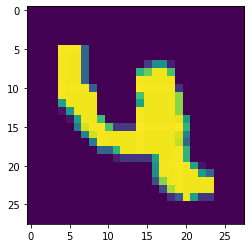

In [8]:
plt.imshow(example_data[0][0])
plt.show

# Network

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

# Training

In [14]:
def train(epoch):
    network.train()
    start = time.time()
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())
    print('Train Epoch: {} Loss: {:.6f}'.format(epoch,loss.item()))
    print("Time elapsed: ", time.time()-start)
    torch.save(network.state_dict(), './results/model.pth')
    torch.save(optimizer.state_dict(), './results/optimizer.pth')

# Testing

In [11]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data = data.to(device)
            target = target.to(device)
            output = network(data)
            test_loss += F.cross_entropy(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [12]:
network = Net()
network = network.to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [16]:
train_losses = []
test_losses = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

  1%|          | 5/938 [00:00<00:19, 48.88it/s]
Test set: Avg. loss: 0.0001, Accuracy: 9641/10000 (96%)

  0%|          | 0/10 [00:00<?, ?it/s]Train Epoch: 1 Loss: 0.338705
Time elapsed:  34.04576015472412
  0%|          | 2/938 [00:00<00:54, 17.16it/s]
Test set: Avg. loss: 0.0001, Accuracy: 9615/10000 (96%)

  0%|          | 0/10 [00:00<?, ?it/s]Train Epoch: 2 Loss: 0.399597
Time elapsed:  33.727588176727295
  1%|▏         | 12/938 [00:00<00:15, 58.80it/s]
Test set: Avg. loss: 0.0001, Accuracy: 9677/10000 (97%)

 10%|█         | 1/10 [00:00<00:01,  6.63it/s]Train Epoch: 3 Loss: 0.130033
Time elapsed:  18.655162572860718
100%|██████████| 10/10 [00:01<00:00,  5.81it/s]
Test set: Avg. loss: 0.0001, Accuracy: 9675/10000 (97%)




# Inference

In [18]:
import cv2
import numpy as np 

model = Net()
model = model.to(device)
model.load_state_dict(torch.load("./results/model.pth"))
model.eval()

transform = torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,))])

In [19]:
def inference(image):
    # load the image
    image = Image.fromarray(image)
    data = transform(image)

    data = data.unsqueeze(0)
    data = data.to(device)
    plt.imshow(image)
    plt.show()

    output = model(data)
    top_p, top_class = output.topk(1, dim = 1)
    print(top_class[0,0].item())

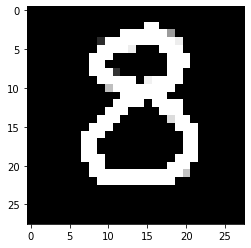

8


In [20]:
drawing = False # true if mouse is pressed
pt1_x , pt1_y = None , None

# mouse callback function
def line_drawing(event,x,y,flags,param):
    global pt1_x,pt1_y,drawing

    if event==cv2.EVENT_LBUTTONDOWN:
        drawing=True
        pt1_x,pt1_y=x,y

    elif event==cv2.EVENT_MOUSEMOVE:
        if drawing==True:
            cv2.line(img,(pt1_x,pt1_y),(x,y),color=(255,255,255),thickness=40)
            pt1_x,pt1_y=x,y
    elif event==cv2.EVENT_LBUTTONUP:
        drawing=False
        cv2.line(img,(pt1_x,pt1_y),(x,y),color=(255,255,255),thickness=40)        


img = np.zeros((512,512,3), np.uint8)
cv2.namedWindow('test draw')
cv2.setMouseCallback('test draw',line_drawing)

while(1):
    cv2.imshow('test draw',img)
    if cv2.waitKey(1) & 0xFF == 27:
        break
    if cv2.waitKey(1) & 0xFF == 32:
        resized = cv2.resize(img, (28,28))
        img = np.zeros((512,512,3), np.uint8)
        inference(resized)
        
cv2.destroyAllWindows()